In [1]:
import os
import pathlib
import sys 
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
sys.path.insert(0, '/srv/data/joeh97/github/SWP-2023-Automatic-Detection-of-Vibratory-Behavior-of-Honeybees' )

In [3]:
import config as cfg
from main import load_gt_items

In [4]:
# Load paths to all pickle files
gt_items = load_gt_items(cfg.PATH_PICKLE) 
def remap(p):
    head = pathlib.Path(cfg.PATH_IMAGES) # actual system path
    tail = p.relative_to("/mnt/curta/storage/beesbook/wdd/")  # path from pickle 
    return head.joinpath(tail) # replace path
gt_items = [tuple(item) + (remap(path),) for *item, path, in gt_items]

all_indices = np.arange(len(gt_items))
print(f"Found {len(all_indices)}  examples")
gt_items = [gt_items[i] for i in all_indices]

gt_items[:4]

Found 1009  examples


[(10902373867864485654,
  'activating',
  1.88699,
  PosixPath('/srv/data/joeh97/data/wdd_ground_truth/wdd_output_2021/cam1/2021/10/2/10/13/13/waggle.json')),
 (14315729783549168726,
  'other',
  1.74699,
  PosixPath('/srv/data/joeh97/data/wdd_ground_truth/wdd_output_2021/cam0/2021/10/3/11/6/2/waggle.json')),
 (15763256288124410364,
  'other',
  2.73699,
  PosixPath('/srv/data/joeh97/data/wdd_ground_truth/wdd_output_2021/cam1/2021/10/9/3/39/1/waggle.json')),
 (17556160191938921872,
  'trembling',
  0.09699,
  PosixPath('/srv/data/joeh97/data/wdd_ground_truth/wdd_output_2021/cam0/2021/10/2/9/44/1/waggle.json'))]

In [5]:
def load_image(f):
    img = Image.open(f)
    img = np.asarray(img, dtype=np.uint8) # uint8 important because pixels are 0-255 (2^0 - 2^8)
    return img

def load_waggle_images(waggle_path):
    '''load images from one directory (= 1 video)'''
    images = []
    waggle_dir = waggle_path.parent
    zip_file_path = os.path.join(waggle_dir, "images.zip")
    assert os.path.exists(zip_file_path) 
    with zipfile.ZipFile(zip_file_path, "r") as zf:
        image_fns = zf.namelist()
        for fn in image_fns:
            with zf.open(fn, "r") as f:
                images.append(load_image(f))
    return images

Select one specfic bee image from one specific directory

In [6]:
# select img
exmpl_path = gt_items[0][3]
exmpl_path

exmpl_imgs = load_waggle_images(exmpl_path)
exmpl_img = exmpl_imgs[0]

In [7]:
print(f'Pixel range [{np.min(exmpl_img)}, {np.max(exmpl_img)}]')

Pixel range [4, 137]


In [11]:
print(f'Shape of one image {exmpl_img.shape} pixels')

Shape of one image (220, 220) pixels


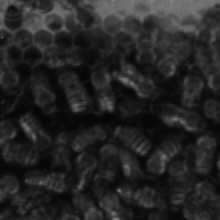

In [9]:
Image.fromarray(exmpl_img, 'L')

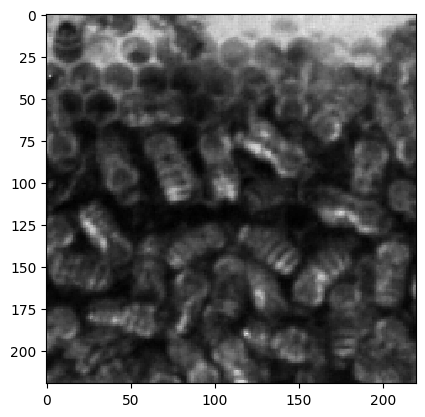

In [10]:
plt.imshow(exmpl_img, interpolation='nearest', cmap='gray')